In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

import dill
import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
import prettypyplot as pplt

In [3]:
from joblib import Memory

In [4]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [5]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [6]:
sys.path.insert(0, "/project/dinner/scguo/kaiB/src")
import statistics

import data
import utils

In [7]:
plt.style.use("custom")  # custom style sheet
plt.style.use("high-contrast")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [8]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

# Load data

In [9]:
home_dir = "/project/dinner/scguo/kaiB"

In [10]:
cvs_all_ts, weights_all_ts = [], []
qlag, qmem = 100, 1
for t in [87, 89, 91]:
    cvs, weights = data.load_all(t)
    cvs_all_ts.append(cvs)
    weights_all_ts.append(weights)

In [11]:
qp_all_ts, qm_all_ts = [], []
for t in [87, 89, 91]:
    with open(f"{home_dir}/dga/new_{t}/data/qp_gs2fs.pkl", mode="rb") as f:
        qp = dill.load(f)[(qlag, qmem)]
        qp = [np.nan_to_num(traj) for traj in qp]
        qp_all_ts.append(qp)
    with open(f"{home_dir}/dga/new_{t}/data/qm_gs2fs.pkl", mode="rb") as f:
        qm = dill.load(f)[(qlag, qmem)]
        qm = [np.nan_to_num(traj) for traj in qm]
        qm_all_ts.append(qm)

In [12]:
labels = dict(
    blue=r"$\beta4_{\mathrm{gs}}\longleftrightarrow\alpha3_{\mathrm{fs}}$",
    green=r"$\alpha3_{\mathrm{gs}}\longleftrightarrow\beta4_{\mathrm{fs}}$",
    orange=r"$\alpha2_{\mathrm{gs}}\longleftrightarrow\beta3_{\mathrm{fs}}$",
    c0=r"$\beta3_{\mathrm{gs}}\longleftrightarrow\alpha2_{\mathrm{fs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{fs, C}}-Q_{\mathrm{gs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1.3, 1),
    green=(-1, 1.3),
    orange=(-1, 1.3),
    c0=(-1.3, 1),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

In [13]:
def define_states(cvs):
    in_fs = (
        (-cvs["green"] < -0.65)
        & (-cvs["blue"] < -0.8)
        & (-cvs["orange"] < -0.85)
        & (cvs["q_fs_all"] > 0.61)
        & (cvs["q_fs"] > 0.75)
        & (cvs["f_rmsds"] < 0.35)
        & (cvs["q_core"] > 0.65)
    )
    in_gs = (
        (-cvs["green"] > 0.55)
        & (-cvs["blue"] > 0.90)
        & (-cvs["orange"] > 0.75)
        & (cvs["q_gs_all"] > 0.62)
        & (cvs["q_gs"] > 0.65)
        & (cvs["p_rmsds"] < 0.45)
        & (cvs["q_core"] > 0.7)
        & (-cvs["c0"] > 0.5)
    )
    return in_fs, in_gs

In [14]:
in_fs_ts, in_gs_ts, in_d_ts = [], [], []
for cvs in cvs_all_ts:
    in_fs, in_gs = define_states(cvs)
    in_fs_ts.append(in_fs)
    in_gs_ts.append(in_gs)
    in_d_ts.append(~(in_fs | in_gs))

# Proline states

In [12]:
from collections import OrderedDict
from itertools import product

In [13]:
def assign_prolines(cvs, weights):
    # assign proline states
    dtrajs = np.zeros_like(cvs["p63"], dtype=int)
    state_dict = OrderedDict()
    fn_seq_iterator = product([lambda x: x, np.logical_not], repeat=2)

    for i, (state, fn_seq) in enumerate(zip(product("CT", repeat=2), fn_seq_iterator)):
        # fn_seq is something like (Identity, ~, Identity, ~)
        seq = (fn_seq[0](cvs["p63"]) & fn_seq[1](cvs["p70"] | cvs["p71"] | cvs["p72"])).astype(bool)
        state_name = "".join(state)
        print(f"{state_name}: {np.sum(weights[seq]) / np.sum(weights) * 100:6.3f}%")
        state_dict[state_name] = i
        dtrajs[seq] = i
    return dtrajs, state_dict

In [14]:
dtrajs_all = []
for cvs, weights in zip(cvs_all_ts, weights_all_ts):
    w = np.array(np.broadcast_to(weights[:, None], cvs["p63"].shape))
    dtrajs, state_dict = assign_prolines(cvs, w)
    print("")
    dtrajs_all.append(dtrajs)

CC:  1.190%
CT:  5.005%
TC: 10.707%
TT: 83.098%

CC:  0.988%
CT:  4.922%
TC: 10.498%
TT: 83.592%

CC:  0.515%
CT:  5.437%
TC:  8.367%
TT: 85.680%



In [55]:
lags = [1, 2, 5, 10, 20, 50, 100, 200]
w = np.array(np.broadcast_to(weights_all_ts[0][:, None], cvs_all_ts[0]["p63"].shape))
w[:, -50:] = 0
mjp = statistics.mjp_current(qp_all_ts[0], qm_all_ts[0], w, in_d_ts[0], dtrajs_all[0], 50, 4)

In [56]:
mjp

array([[1.58606598e-04, 1.12660360e-05, 3.19441534e-05, 5.16475488e-06],
       [1.12937650e-05, 1.24320513e-03, 4.64083507e-06, 3.45642929e-04],
       [3.21624748e-05, 4.76388199e-06, 2.29881867e-03, 2.88271144e-04],
       [4.81585821e-06, 3.45477579e-04, 2.87784596e-04, 2.51149719e-02]])

In [59]:
net_flux = np.maximum(mjp - mjp.T, 0)

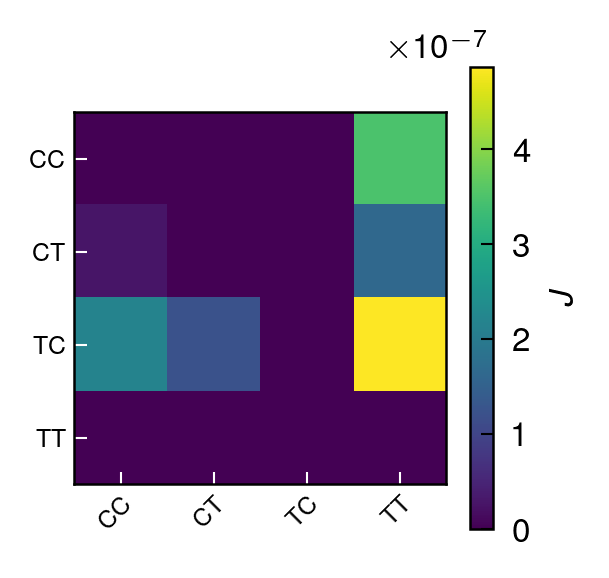

In [86]:
f = plt.figure(dpi=300, figsize=(2, 2))
plt.imshow(net_flux)
plt.colorbar(label=r"$J$")
ax = plt.gca()
ax.set_yticks(np.arange(4), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(4),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [73]:
w.shape

(22826, 1001)

In [81]:
qp_p, qm_p, pi_p = np.zeros(4), np.zeros(4), np.zeros(4)
for i in range(4):
    w = weights_all_ts[0]
    qp_p[i] = utils.pi_avg_state(qp_all_ts[0], w, (dtrajs_all[0] == i))
    qm_p[i] = utils.pi_avg_state(qm_all_ts[0], w, (dtrajs_all[0] == i))
    pi_p[i] = utils.pop_state(w, (dtrajs_all[0] == i))

In [82]:
qp_p, qm_p, pi_p

(array([0.6007419 , 0.16347503, 0.41269093, 0.13097077]),
 array([0.08457324, 0.30235577, 0.15898526, 0.34791575]),
 array([0.01190327, 0.050054  , 0.10706569, 0.83097705]))

(<Figure size 1800x1800 with 1 Axes>,
 array([[0.6007419 , 0.3882791 ],
        [0.16347503, 0.46977113],
        [0.41269093, 0.        ],
        [0.13097077, 0.35456038]]))

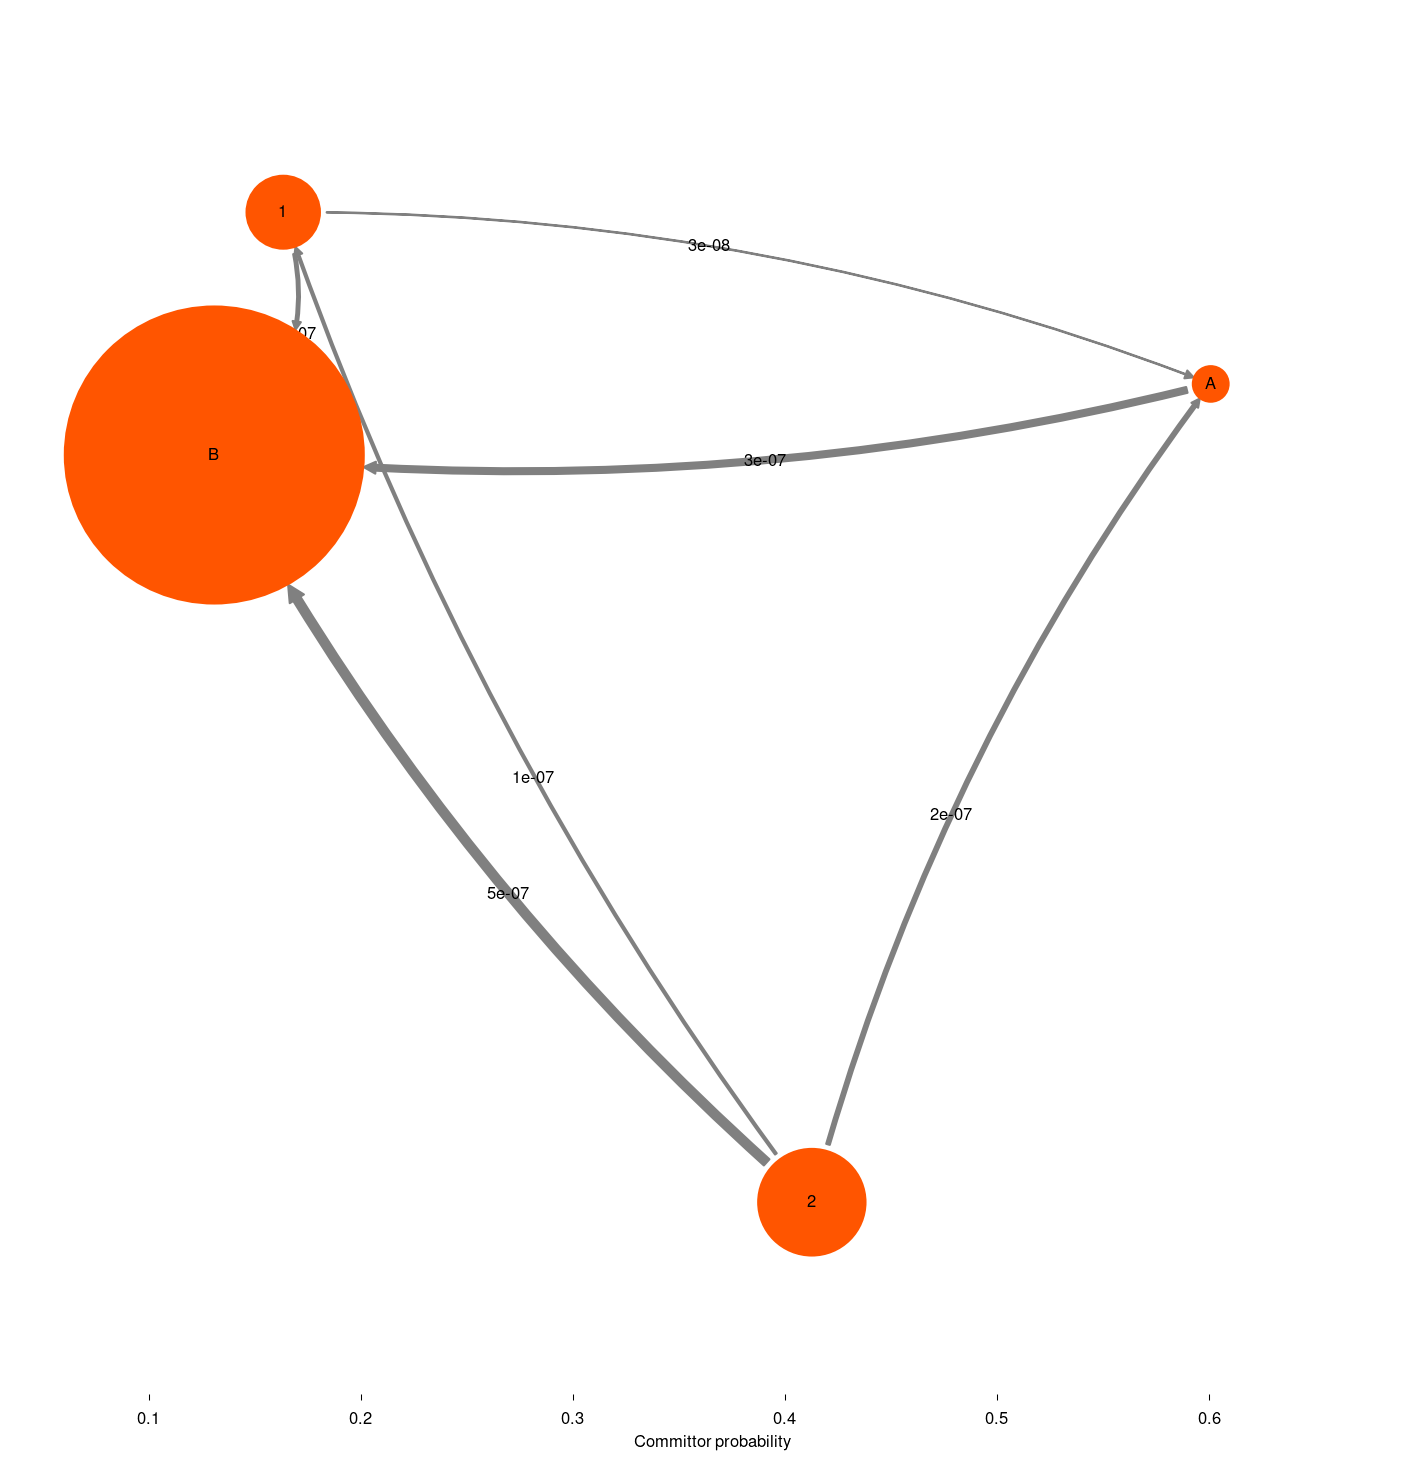

In [83]:
rflux = pyemma.msm.ReactiveFlux([0], [3], net_flux, mu=pi_p, qminus=qm_p, qplus=qp_p)
pyemma.plots.plot_flux(rflux)

In [85]:
all_fluxes = dict()
lags = [1, 2, 5, 10, 20, 50, 100, 200]
for t, qp, qm, w, in_d, dtrajs in zip(
    [87, 89, 91], qp_all_ts, qm_all_ts, weights_all_ts, in_d_ts, dtrajs_all
):
    w = np.array(np.broadcast_to(w[:, None], np.asarray(qp).shape))
    for lag in lags:
        w[:, -lag:] = 0
        print(f"Computing reactive flux for T={t} and lag={lag}")
        mjp = statistics.mjp_current(qp, qm, w, in_d, dtrajs, lag, 4)
        all_fluxes[(t, lag)] = mjp

Computing reactive flux for T=87 and lag=1
Computing reactive flux for T=87 and lag=2
Computing reactive flux for T=87 and lag=5
Computing reactive flux for T=87 and lag=10
Computing reactive flux for T=87 and lag=20
Computing reactive flux for T=87 and lag=50
Computing reactive flux for T=87 and lag=100
Computing reactive flux for T=87 and lag=200
Computing reactive flux for T=89 and lag=1
Computing reactive flux for T=89 and lag=2
Computing reactive flux for T=89 and lag=5
Computing reactive flux for T=89 and lag=10
Computing reactive flux for T=89 and lag=20
Computing reactive flux for T=89 and lag=50
Computing reactive flux for T=89 and lag=100
Computing reactive flux for T=89 and lag=200
Computing reactive flux for T=91 and lag=1
Computing reactive flux for T=91 and lag=2
Computing reactive flux for T=91 and lag=5
Computing reactive flux for T=91 and lag=10
Computing reactive flux for T=91 and lag=20
Computing reactive flux for T=91 and lag=50
Computing reactive flux for T=91 and 

/scratch/local/jobs/18226894/ipykernel_389600/1231557916.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(net_flux))


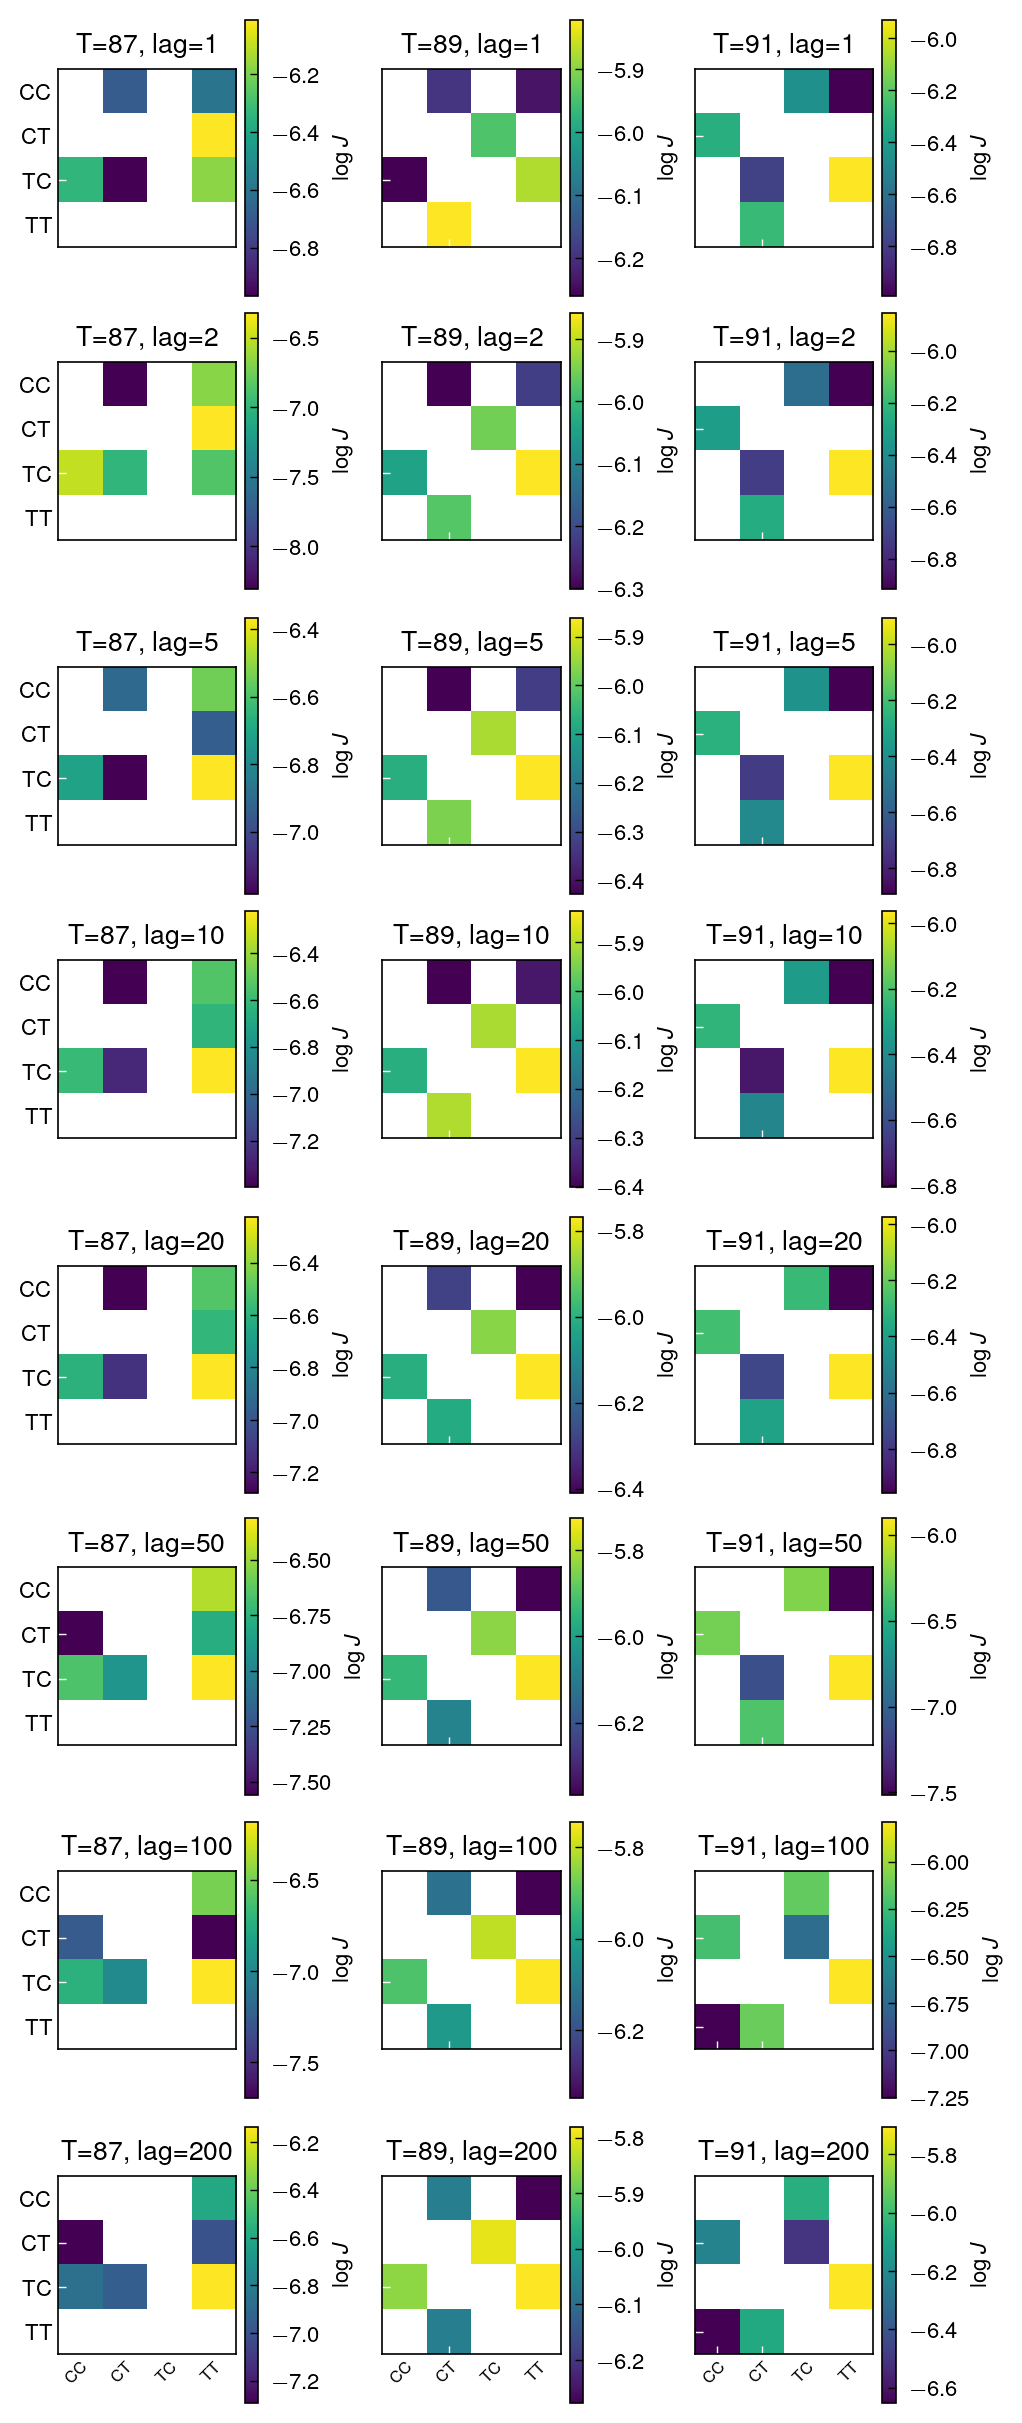

In [122]:
f, axes = plt.subplots(nrows=len(lags), ncols=3, dpi=200, figsize=(5, 12), constrained_layout=True)
for i, t in enumerate([87, 89, 91]):
    for j, lag in enumerate(lags):
        ax = axes[j, i]
        mjp = all_fluxes[(t, lag)]
        net_flux = np.maximum(mjp - mjp.T, 0)
        im = ax.imshow(np.log10(net_flux))
        plt.colorbar(im, ax=ax, label=r"$\log J$")
        ax.set_yticks(np.arange(4), state_dict.keys(), fontfamily="monospace")
        ax.set_xticks(
            np.arange(4),
            state_dict.keys(),
            ha="right",
            rotation_mode="anchor",
            rotation=45,
            fontsize=6,
            fontfamily="monospace",
        )
        ax.tick_params(color="white", pad=2)
        ax.set_title(f"T={t}, lag={lag}")
        ax.label_outer()

In [123]:
state_dict.keys()

odict_keys(['CC', 'CT', 'TC', 'TT'])

/scratch/local/jobs/18226894/ipykernel_389600/825731253.py:8: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(net_flux[cc_order, :][:, cc_order]))


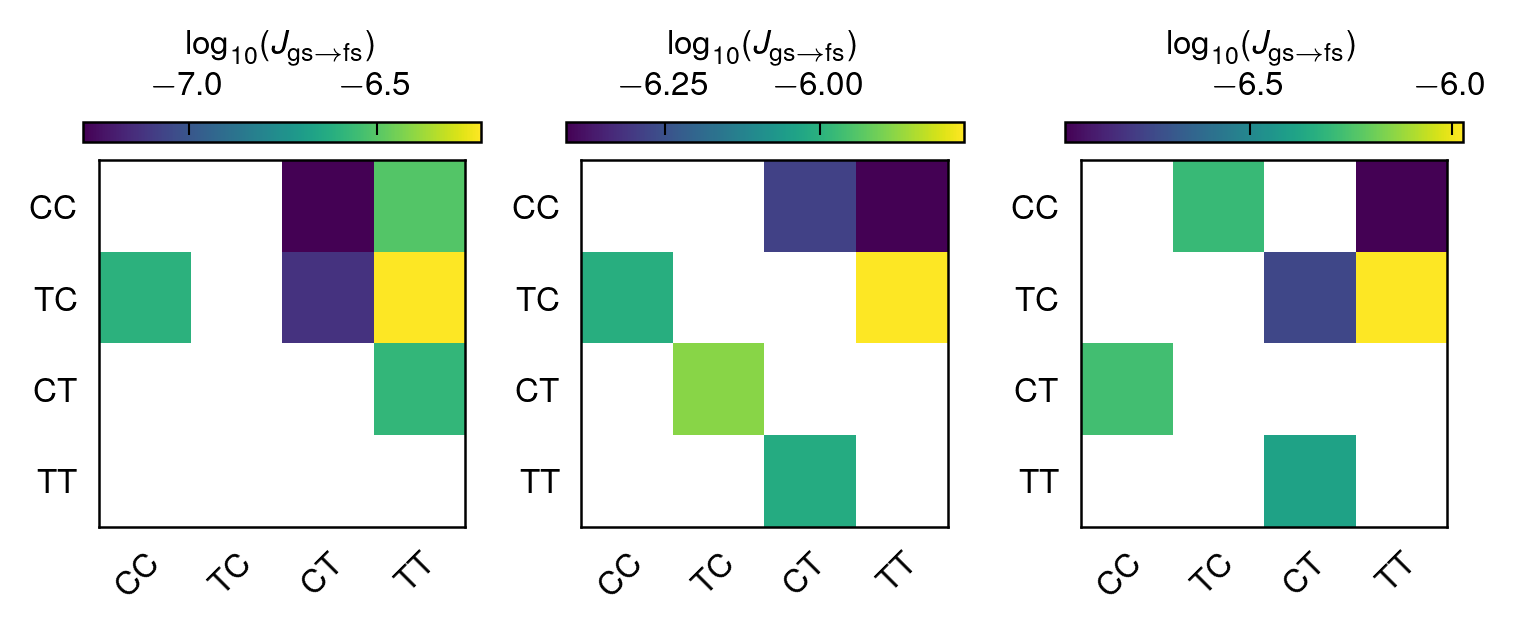

In [127]:
f, axes = plt.subplots(ncols=3, dpi=300, figsize=(5, 2), constrained_layout=True)
lag = 20
cc_order = [0, 2, 1, 3]
ax_labels = ["CC", "TC", "CT", "TT"]
for ax, t in zip(axes, [87, 89, 91]):
    mjp = all_fluxes[(t, lag)]
    net_flux = np.maximum(mjp - mjp.T, 0)
    im = ax.imshow(np.log10(net_flux[cc_order, :][:, cc_order]))
    plt.colorbar(im, ax=ax, label=r"$\log_{10} (J_{\mathrm{gs}\rightarrow\mathrm{fs}})$", location="top")
    ax.set_yticks(np.arange(4), ax_labels, fontfamily="monospace")
    ax.set_xticks(
        np.arange(4),
        ax_labels,
        ha="right",
        rotation_mode="anchor",
        rotation=45,
        fontfamily="monospace",
    )
    ax.tick_params(length=0)

# projections

/scratch/local/jobs/18226894/ipykernel_389600/1823903829.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)


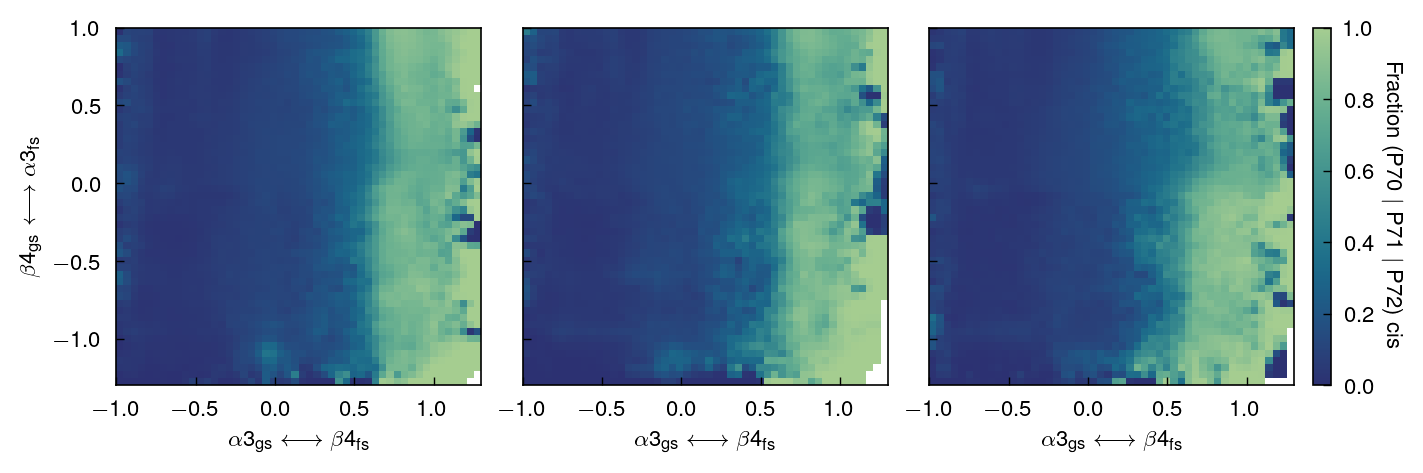

In [101]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "blue"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs["p70"] | cvs["p71"] | cvs["p72"]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"Fraction (P70 $|$ P71 $|$ P72) cis", rotation=-90, labelpad=10)

# fig.savefig(f"{figure_dir}/p7072_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18226894/ipykernel_389600/971710125.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)


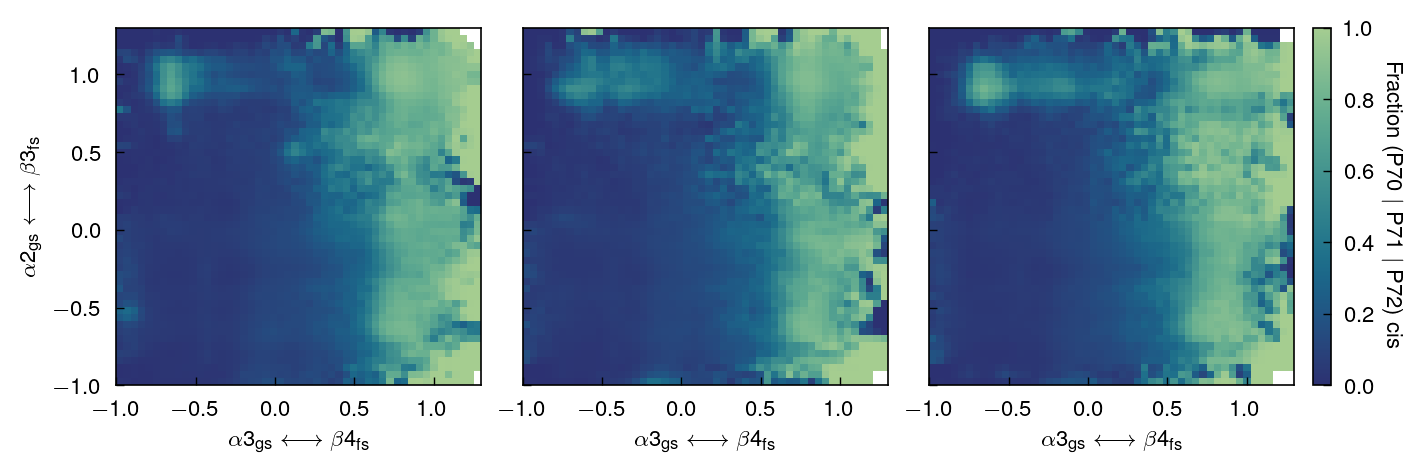

In [132]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "orange"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs["p70"] | cvs["p71"] | cvs["p72"]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"Fraction (P70 $|$ P71 $|$ P72) cis", rotation=-90, labelpad=10)

# fig.savefig(f"{figure_dir}/p7072_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18226894/ipykernel_389600/1941442028.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)


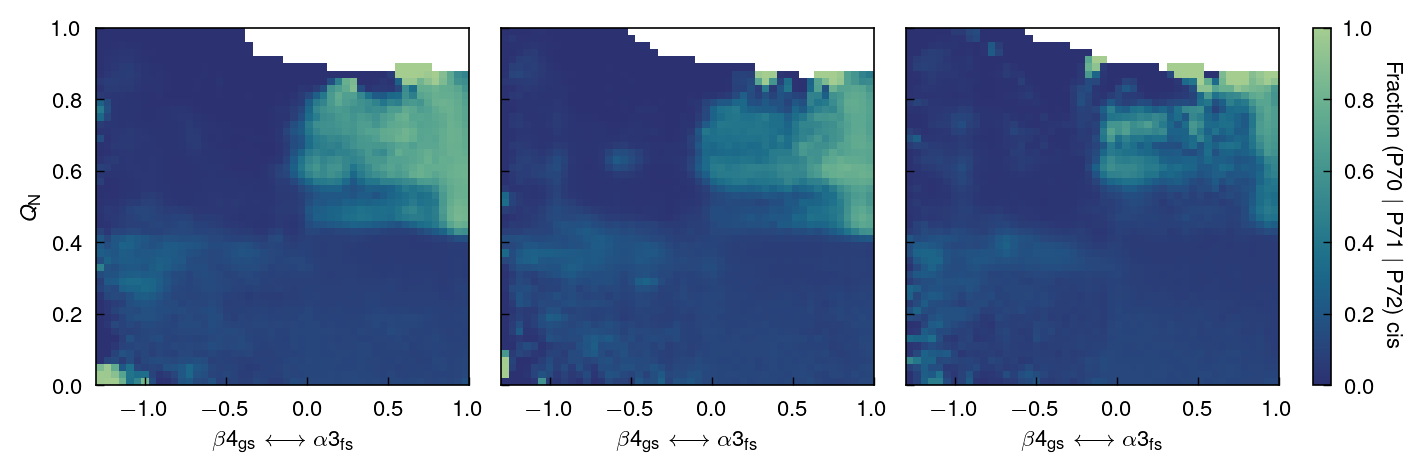

In [102]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "blue"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs["p70"] | cvs["p71"] | cvs["p72"]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"Fraction (P70 $|$ P71 $|$ P72) cis", rotation=-90, labelpad=10)
# fig.savefig(f"{figure_dir}/p7072_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18226894/ipykernel_389600/1518071998.py:31: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=lims[cv3][0], vmax=lims[cv3][1], rasterized=True)


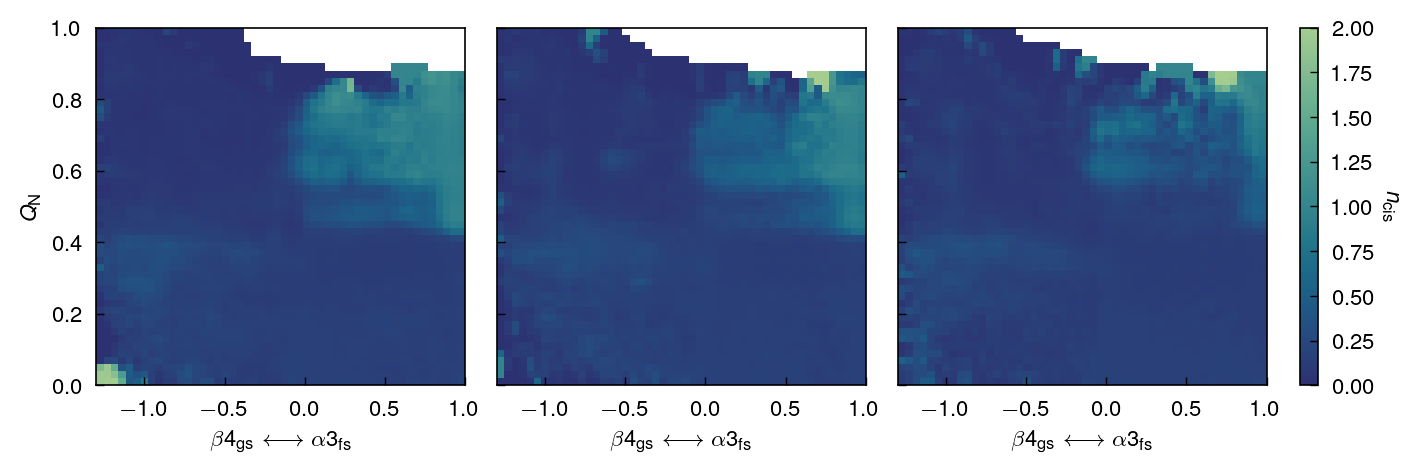

In [103]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "blue"
cv2 = "q_core"
cv3 = "n_cis"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs[cv3]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=lims[cv3][0], vmax=lims[cv3][1], rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=labels[cv3], rotation=-90, labelpad=10)
# fig.savefig(f"{figure_dir}/p7072_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18226894/ipykernel_389600/1128182817.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)


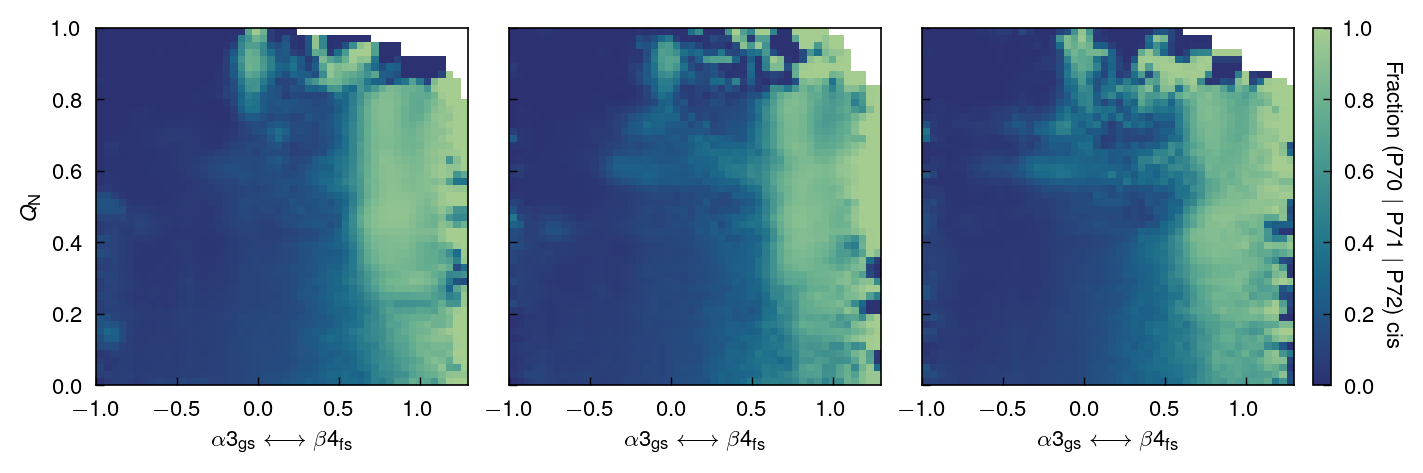

In [104]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs["p70"] | cvs["p71"] | cvs["p72"]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"Fraction (P70 $|$ P71 $|$ P72) cis", rotation=-90, labelpad=10)
# fig.savefig(f"{figure_dir}/p7072_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18226894/ipykernel_389600/4253245949.py:31: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1.5, rasterized=True)


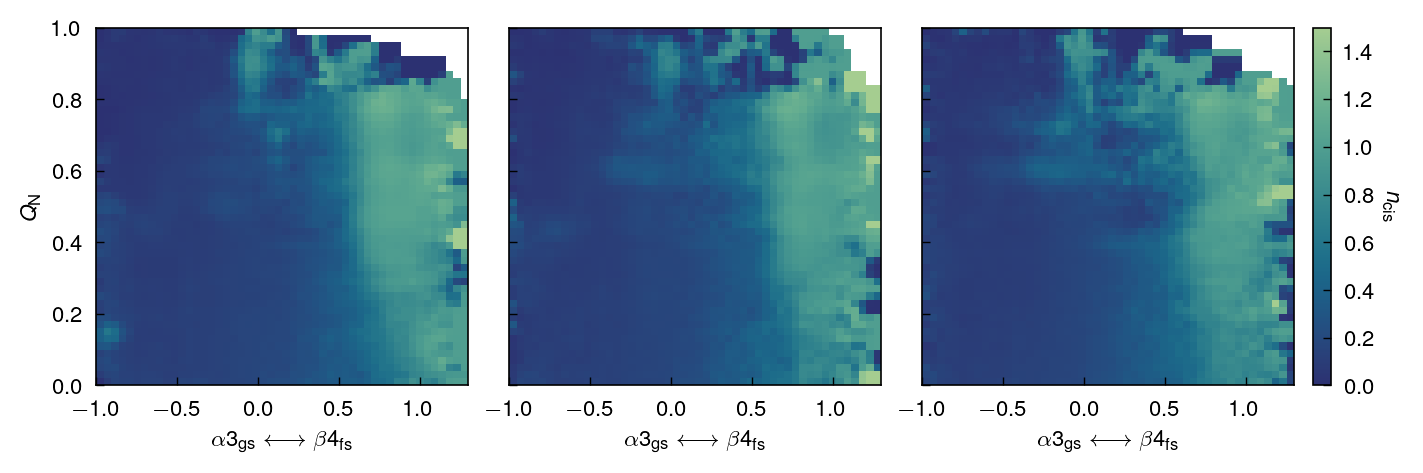

In [130]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "q_core"
cv3 = "n_cis"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs[cv3]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1.5, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=labels[cv3], rotation=-90, labelpad=10)
# fig.savefig(f"{figure_dir}/p7072_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

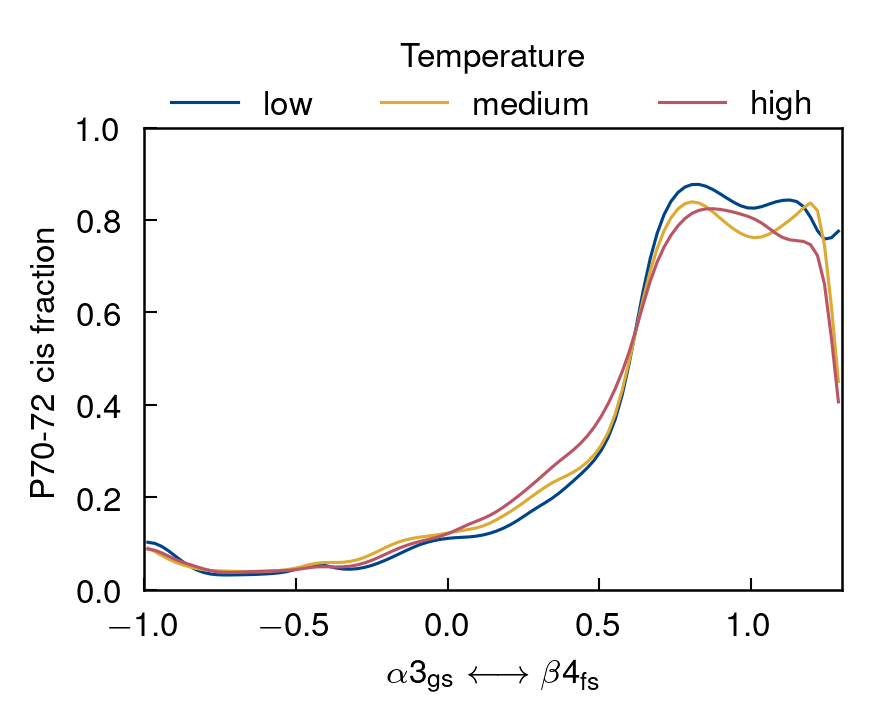

In [20]:
# combine p70-p72
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.04
nx = 100
handles = []
labs = ["low", "medium", "high"]
cv = "green"
for w, cvs, label in zip(weights_all_ts, cvs_all_ts, labs):
    x = np.asarray(cvs[cv])
    w = np.broadcast_to(w[..., None], x.shape)
    y = cvs['p70'] | cvs['p71'] | cvs['p72']
    numer, xe = utils.kdesum1d(x, y * w, xmin=lims[cv][0], xmax=lims[cv][1], xstd=xstd, nx=nx)
    denom, _ = utils.kdesum1d(x, w, xmin=lims[cv][0], xmax=lims[cv][1], xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(labels[cv])
plt.ylabel("P70-72 cis fraction")
plt.xlim(lims[cv])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
fig.savefig("../../dga/figures/green_p7072_ts.pdf", bbox_inches='tight')
plt.show()

# check structures

In [105]:
def get_trajfiles(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    traj_files = []
    for i in range(1, 12289):
        j = i // 1000
        for iso in ("cis", "trans"):
            head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
            listed = glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.h5")
            if len(listed) != 0:
                traj_files.extend(listed)
    return traj_files

In [106]:
all_trajfiles = {}
for t in (87, 89, 91):
    all_trajfiles[t] = get_trajfiles(t)

In [107]:
def load_and_save(t, traj_id):
    trajfile = all_trajfiles[t][traj_id]
    print(trajfile)
    traj = md.load(trajfile)
    traj.save_xtc(os.path.join(os.path.dirname(trajfile), "traj.xtc"))

## what is green transition doing when p71 switches?

In [109]:
cvs = cvs_all_ts[0]
p7072 = cvs["p70"] | cvs["p71"] | cvs["p72"]
stackedcvs = np.dstack((p7072, cvs['green']))
point = [1, 0.6]
print(np.argsort(np.mean((stackedcvs - point) ** 2, axis=(1,2)))[:10])

[11917 12467  3452  4350  3581  3656  4500  4351  4546  3342]


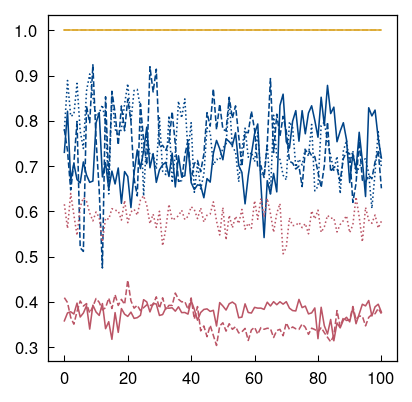

In [117]:
for (trajid, ls) in zip([11917, 12467, 3452], ['-', '--', ':']):
    plt.plot(cvs['green'][trajid, ::10], color='C0', ls=ls)
    plt.plot(p7072[trajid, ::10], color='C1', ls=ls)
    plt.plot(cvs['q_core'][trajid, ::10], color='C2', ls=ls)

In [118]:
load_and_save(87, 11917)
load_and_save(87, 12467)
load_and_save(87, 3452)

/project/dinner/scguo/kaiB/dga/new_87/06/06244/cis/rerun_0_03_03.run.h5
/project/dinner/scguo/kaiB/dga/new_87/06/06753/trans/rerun_0_19_00.run.h5
/project/dinner/scguo/kaiB/dga/new_87/01/01783/cis/fs_p2.5_07_22.run.h5


In [119]:
cvs = cvs_all_ts[0]
p7072 = cvs["p70"] | cvs["p71"] | cvs["p72"]
stackedcvs = np.dstack((p7072, cvs['green']))
point = [0, 0.6]
print(np.argsort(np.mean((stackedcvs - point) ** 2, axis=(1,2)))[:10])

[21792 20777 20647 20269 20790 20268 20531 20894  4598 20882]


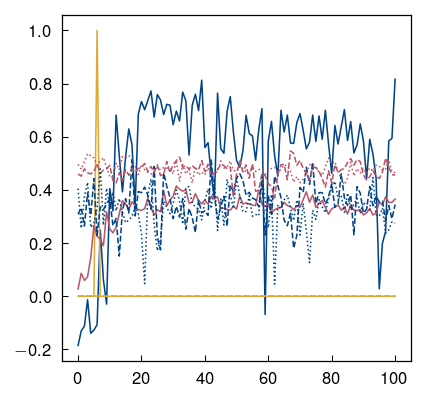

In [120]:
for (trajid, ls) in zip([21792, 20777, 20647], ['-', '--', ':']):
    plt.plot(cvs['green'][trajid, ::10], color='C0', ls=ls)
    plt.plot(p7072[trajid, ::10], color='C1', ls=ls)
    plt.plot(cvs['q_core'][trajid, ::10], color='C2', ls=ls)

In [121]:
load_and_save(87, 21792)
load_and_save(87, 20777)
load_and_save(87, 20647)

/project/dinner/scguo/kaiB/dga/new_87/11/11772/cis/rerun_3_31_27.run.h5
/project/dinner/scguo/kaiB/dga/new_87/11/11264/trans/rerun_3_15_31.run.h5
/project/dinner/scguo/kaiB/dga/new_87/11/11199/trans/rerun_3_13_30.run.h5


In [128]:
cvs = cvs_all_ts[0]
p7072 = cvs["p70"] | cvs["p71"] | cvs["p72"]
stackedcvs = np.dstack((p7072, cvs['green']))
point = [0.5, 0.7]
print(np.argsort(np.mean((stackedcvs - point) ** 2, axis=(1,2)))[:10])

[ 4495 11917  3515  4350  3452 12474  4649  3581 12467  4054]


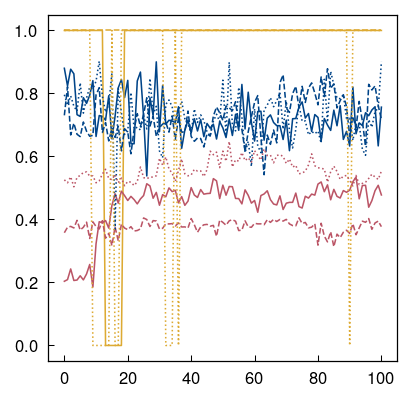

In [129]:
for (trajid, ls) in zip([4495, 11917, 3515], ['-', '--', ':']):
    plt.plot(cvs['green'][trajid, ::10], color='C0', ls=ls)
    plt.plot(p7072[trajid, ::10], color='C1', ls=ls)
    plt.plot(cvs['q_core'][trajid, ::10], color='C2', ls=ls)

In [131]:
load_and_save(87, 4495)
load_and_save(87, 11917)
load_and_save(87, 3515)

/project/dinner/scguo/kaiB/dga/new_87/02/02304/trans/fs_p2.5_23_31.run.h5
/project/dinner/scguo/kaiB/dga/new_87/06/06244/cis/rerun_0_03_03.run.h5


/beagle3/dinner/scguo/envs/md/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


/project/dinner/scguo/kaiB/dga/new_87/01/01814/trans/fs_p2.5_08_21.run.h5
